# Create txt split

In [23]:
import json
import pandas as pd
import os
with open('../_data/fashionpedia/ann_dir/instances_attributes_train2020.json') as f:
    data_train = json.load(f)
    images_train = pd.DataFrame(data_train['images'])
    annotations_train = pd.DataFrame(data_train['annotations'])
    categories_train = pd.DataFrame(data_train['categories'])

with open('../_data/fashionpedia/ann_dir/instances_attributes_val2020.json') as f:
    data_val = json.load(f)
    images_val = pd.DataFrame(data_val['images'])
    annotations_val = pd.DataFrame(data_val['annotations'])
    categories_val = pd.DataFrame(data_val['categories'])

In [24]:
images_train['file_name'] = images_train['file_name'].apply(lambda x: os.path.splitext(x)[0])
images_val['file_name'] = images_val['file_name'].apply(lambda x: os.path.splitext(x)[0])
for index, row in images_train.iterrows():
    filename = row['file_name']
    file_path = '../_data/fashionpedia/ann_dir/train/' + filename.split('.')[0] + '_seg.png'
    if not os.path.exists(file_path):
        images_train.drop(index, inplace=True)

for index, row in images_val.iterrows():
    filename = row['file_name']
    file_path = '../_data/fashionpedia/ann_dir/val/' + filename.split('.')[0] + '_seg.png'
    if not os.path.exists(file_path):
        images_val.drop(index, inplace=True)

In [25]:
filenames_train = images_train['file_name']
filenames_train.to_csv('../_data/fashionpedia/train_files.txt', sep='\t', index=False, header=False)

filenames_val = images_val['file_name']
filenames_val.to_csv('../_data/fashionpedia/val_files.txt', sep='\t', index=False, header=False)

# Train

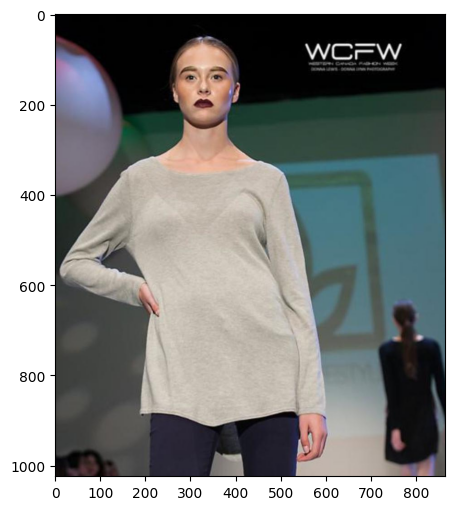

In [1]:
import mmcv
import mmengine
import matplotlib.pyplot as plt
import numpy as np
from mmengine import Config
from PIL import Image
import matplotlib.patches as mpatches
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

img = mmcv.imread('../_data/fashionpedia/img_dir/train/0a3e75ac695e2a5673c9d1e1356e14a2.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [14]:
def generate_palette(num_classes, seed=42):
    """
    Generate a palette for MMSegmentation given the number of classes.

    Args:
        num_classes (int): Number of classes.

    Returns:
        list: Palette list of tuples of length `num_classes` in BGR format.
    """
    np.random.seed(seed)
    palette = []

    # Generate BGR colors
    for i in range(num_classes):
        if i == 0:
            # The first color is reserved for background
            palette.append((0, 0, 0))  # Background color (Black)
            continue
        else:
            b = np.random.randint(0, 256)
            g = np.random.randint(0, 256)
            r = np.random.randint(0, 256)
            palette.append((b, g, r))  # BGR format

    return palette

In [15]:
data_root = '../_data/fashionpedia'
img_dir = 'img_dir'
ann_dir = 'ann_dir'

classes = ('background', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel')
palette = generate_palette(len(classes))

<Figure size 800x600 with 0 Axes>

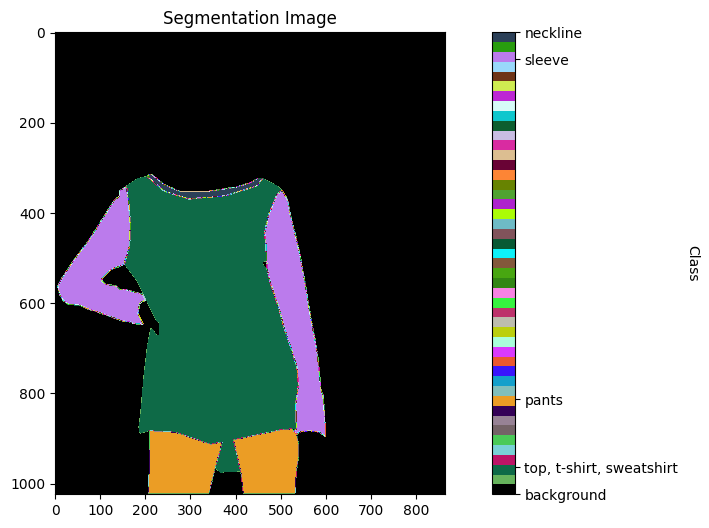

In [16]:
img = Image.open('../_data/fashionpedia/ann_dir/train/0a3e75ac695e2a5673c9d1e1356e14a2_seg.png')
plt.figure(figsize=(8, 6))

# Convert the image to a NumPy array
img_array = np.array(img)

# Extract unique attributes from the image
unique_attributes = np.unique(img_array)

# Create a custom colormap from the palette
cmap = plt.matplotlib.colors.ListedColormap([np.array(color)/255. for color in palette])

# Create a figure
plt.figure(figsize=(12, 6))

# Plot the segmentation image with the custom colormap
im = plt.imshow(img_array, cmap=cmap)
plt.title('Segmentation Image')

# Create a custom colorbar as the legend
cbar = plt.colorbar(im, ticks=unique_attributes, orientation='vertical')
cbar.ax.set_yticklabels([classes[attr] for attr in unique_attributes])
cbar.set_label('Class', rotation=270, labelpad=15)

# Show the plot
plt.show()

In [5]:
@DATASETS.register_module()
class FashionpediaDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='_seg.png', **kwargs)

In [6]:
cfg = Config.fromfile('../mmsegmentation/configs/ocrnet/ocrnet_hr18_4xb2-160k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=16000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1

In [7]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (192, 192)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# Modify dataset type and path
cfg.dataset_type = 'FashionpediaDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 2

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir+'/train', seg_map_path=ann_dir+'/train')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'train_files.txt'
cfg.train_dataloader.persistent_workers = False
cfg.train_dataloader.num_workers = 0

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir+'/val', seg_map_path=ann_dir+'/val')
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'val_files.txt'
cfg.val_dataloader.persistent_workers = False
cfg.val_dataloader.num_workers = 0
cfg.val_evaluator.iou_metrics = ['mDice']

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'ocrnet_hr18_512x1024_160k_cityscapes_20200602_191001-b9172d0c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 10
cfg.train_cfg.val_interval = 10
cfg.default_hooks.logger.interval = 5
cfg.default_hooks.checkpoint.interval = 10

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    192,
    192,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = '../_data/fashionpedia'
dataset_type = 'FashionpediaDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=10, type='CheckpointHook'),
    logger=dict(interval=5, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
   

In [8]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/08 12:19:53 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce GTX 1650
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v.12.3
    MSVC: n/a, reason: fileno
    PyTorch: 2.0.0
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-ge

c:\users\laia\onedrive - universitat politècnica de catalunya\2nd semester\or\p2\or-p2\mmsegmentation\mmseg\models\backbones\hrnet.py:318: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
c:\users\laia\onedrive - universitat politècnica de catalunya\2nd semester\or\p2\or-p2\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/08 12:19:56 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
04/08 12:19:56 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

c:\users\laia\onedrive - universitat politècnica de catalunya\2nd semester\or\p2\or-p2\mmsegmentation\mmseg\engine\hooks\visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [9]:
runner.train()

04/08 12:19:58 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
04/08 12:20:00 - mmengine - INFO - load model from: open-mmlab://msra/hrnetv2_w18
04/08 12:20:00 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://msra/hrnetv2_w18
04/08 12:20:01 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: incre_modules.0.0.conv1.weight, incre_modules.0.0.bn1.weight, incre_modules.0.0.bn1.bias, incre_modules.0.0.bn1.running_mean, incre_modules.0.0.bn1.running_var, incre_modules.0.0.bn1.num_batches_tracked, incre_modules.0.0.conv2.weight, incre_modules.0.0.bn2.weight, incre_modules.0.0.bn2.bias, incre_modules.0.0.bn2.running_mean, incre_modules.0.0.bn2.running_var, incre_modules.0.0.bn2.num_batches_tracked, incre_modules.0.0.conv3.weight, incre_modules.0.0.bn3.weight, incre_modules.0.0.bn3.bias, incre_modules.0.0.bn3.running_mean, incre_modules.0.0.bn3.running_var, incre_modules.0.0.b

CascadeEncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): HRNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm

Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_10.pth


c:\Users\Laia\miniconda3\envs\openmmlab\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


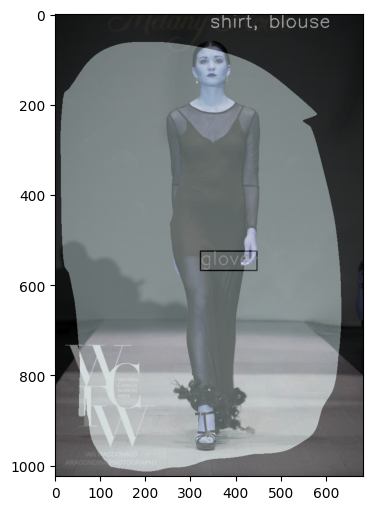

In [13]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_10.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')
model.dataset_meta = dict(classes = classes, palette = palette)
img = mmcv.imread('../_data/fashionpedia/img_dir/val/fe386ea7e5225f7692da85b82a018d65.jpg')
img = mmcv.bgr2rgb(img)

result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))